In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/wce_endoscopy_dataset/

/content/drive/MyDrive/wce_endoscopy_dataset


In [ ]:
!unzip archive.zip

Archive:  archive.zip
replace test/0_normal/test_normal_ (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Proposed Model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Multiply, Conv2D, Activation, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Randomly apply shearing
    zoom_range=0.2,  # Randomly zoom in/out
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode="nearest",  # Fill pixels after augmentation
)

# No augmentation for validation and testing sets; only rescaling
test_val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    "train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
)
val_generator = test_val_datagen.flow_from_directory(
    "val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
)
test_generator = test_val_datagen.flow_from_directory(
    "test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
)

# Attention mechanism
def attention_layer(inputs):
    """Simple attention mechanism to focus on important features."""
    # Global Average Pooling
    attention = GlobalAveragePooling2D()(inputs)
    # Dense Layer
    attention = Dense(K.int_shape(inputs)[-1] // 4, activation="relu")(attention)
    attention = Dense(K.int_shape(inputs)[-1], activation="sigmoid")(attention)
    # Reshape to match input dimensions
    attention = Reshape([1, 1, K.int_shape(inputs)[-1]])(attention)
    # Apply attention (multiply input features by attention weights)
    attention = Multiply()([inputs, attention])
    return attention

# Model architecture with EfficientNetB0 and attention
input_tensor = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=input_tensor)

# Add attention mechanism
x = base_model.output
x = attention_layer(x)  # Apply attention
# Add a dropout layer after attention to reduce overfitting
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)  # Pooling layer
#x = Dense(256, activation="relu")(x)  # Fully connected layer
x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Dropout after dense layer
#output_tensor = Dense(train_generator.num_classes, activation="softmax")(x)  # Output layer
output_tensor = Dense(train_generator.num_classes, activation="softmax", kernel_regularizer=l2(0.01))(x)
# Define the final model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history8 = model.fit(train_generator, validation_data=val_generator, epochs=20)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model.save("efficientnetb0_with_attention.h5")


Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 3443s 32s/step - accuracy: 0.3482 - loss: 5.6761 - val_accuracy: 0.2500 - val_loss: 5.6529
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 95s 893ms/step - accuracy: 0.5826 - loss: 5.4338 - val_accuracy: 0.2435 - val_loss: 5.5710
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 905ms/step - accuracy: 0.7547 - loss: 5.1756 - val_accuracy: 0.2840 - val_loss: 5.4841
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 893ms/step - accuracy: 0.8552 - loss: 4.8642 - val_accuracy: 0.2320 - val_loss: 5.4128
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 143s 888ms/step - accuracy: 0.8831 - loss: 4.5816 - val_accuracy: 0.5010 - val_loss: 5.1484
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.9220 - loss: 4.3225 - val_accuracy: 0.7230 - val_loss: 4.6364
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 893ms/step - accuracy: 0.9362 - loss: 4.1390 - val_accuracy: 0.8235 - val_loss: 4.2728
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.9388 - loss: 4.0002 - val_ac

Test Loss: 2.8385660648345947
Test Accuracy: 0.9275000095367432


In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss graphs
def plot_history(history, model_name="Model"):
    # Extract metrics from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()




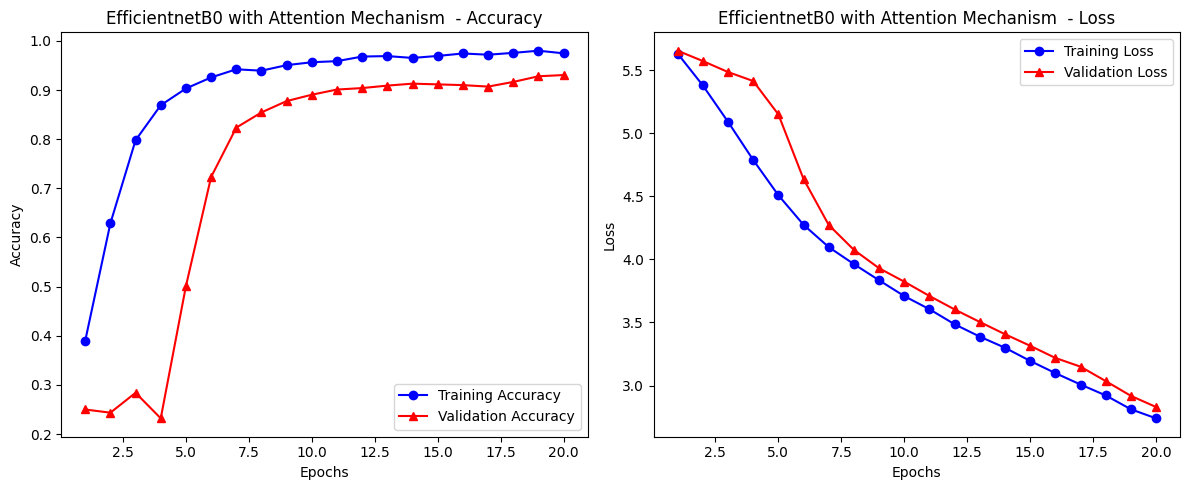

In [ ]:
# Plotting for EfficientNetB2
plot_history(history8, model_name="EfficientnetB0 with Attention Mechanism ")

25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 533ms/step
Classification Report:
                      precision    recall  f1-score   support

            0_normal       0.99      0.99      0.99       200
1_ulcerative_colitis       0.87      0.84      0.86       200
            2_polyps       0.87      0.88      0.87       200
       3_esophagitis       0.99      0.99      0.99       200

            accuracy                           0.93       800
           macro avg       0.93      0.93      0.93       800
        weighted avg       0.93      0.93      0.93       800

F1 Score (Weighted): 0.9272


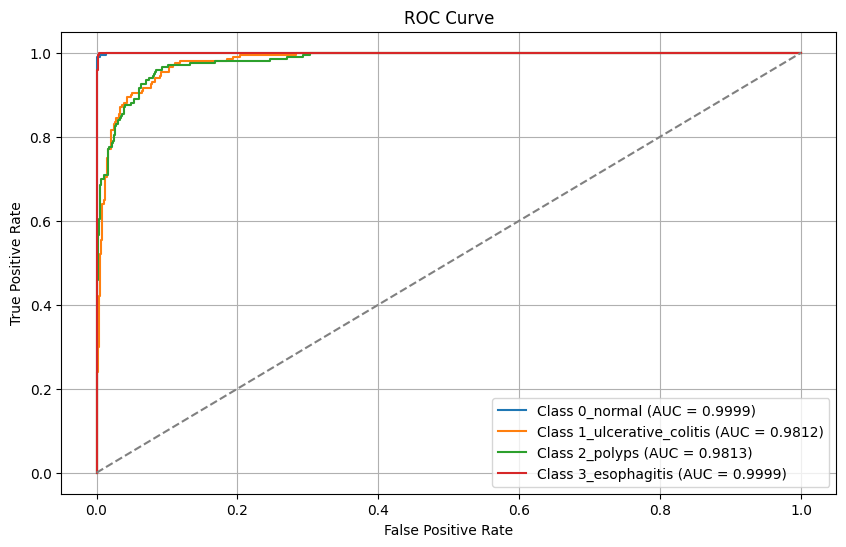

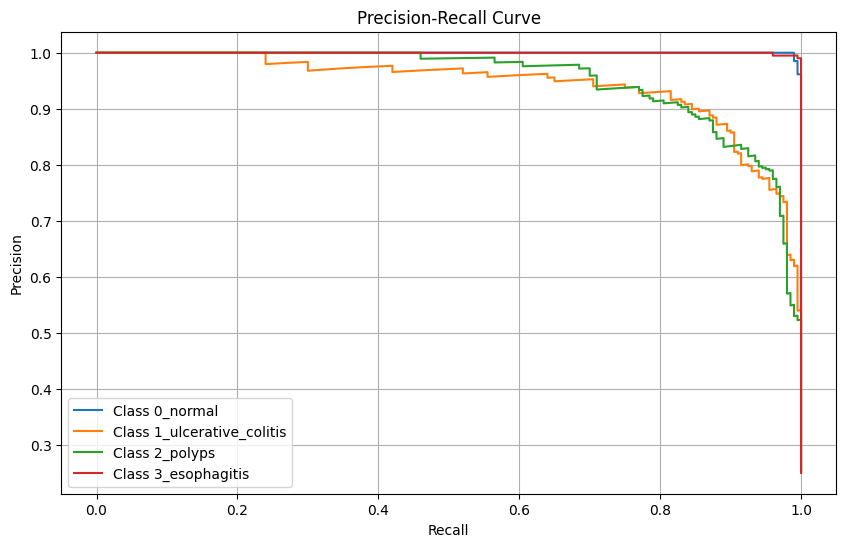

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_multiclass(model, test_generator):
    """Evaluate the model and plot precision-recall and ROC curves for multiclass classification."""
    # Get true labels and predictions
    true_labels = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    # One-hot encode the true labels for multiclass ROC and PR curves
    true_labels_one_hot = label_binarize(true_labels, classes=np.arange(len(class_labels)))

    # Classification Report
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_labels))

    # Calculate F1 Score (weighted)
    f1 = f1_score(true_labels, predicted_labels, average="weighted")
    print(f"F1 Score (Weighted): {f1:.4f}")

    # ROC Curve and AUC for each class
    plt.figure(figsize=(10, 6))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {class_labels[i]} (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Precision-Recall Curve for each class
    plt.figure(figsize=(10, 6))
    for i in range(len(class_labels)):
        precision, recall, _ = precision_recall_curve(true_labels_one_hot[:, i], predictions[:, i])
        plt.plot(recall, precision, label=f"Class {class_labels[i]}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

# Call the function to evaluate the model
evaluate_model_multiclass(model, test_generator)
